# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

### 1.1 Изучение данных 

In [1]:
import pandas as pd
import numpy as np
from  matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.utils import shuffle
from sklearn.metrics import  roc_auc_score
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### 1.3 Удаление лишних столбцов

В датасете есть данные , которые не оказывают влияния на целевой признак, при этом могут снизить качество обучения модели: 

'RowNumber' - номер строки (дублирует индекс)

'CustomerId' - уникальный номер клиента. Не может оказывать влияния на целевой признак

'Surname' - фамилия клинта, то же случайная величина как  ID и ни как не может влиять на целевой признак

Удалим их

In [6]:
df.drop(['RowNumber', 'CustomerId','Surname'], axis = 1 , inplace = True)

In [7]:
df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


### 1.4 Замена пропусков

В данных о наличии недвижимости есть пропуски. Поищем причину пропусков. 

In [8]:
tenure = df[df['Tenure'].isnull()]

In [9]:
tenure.loc[tenure.loc[:,'Exited'] ==0].shape, tenure.loc[tenure.loc[:,'Exited'] ==1].shape

((726, 11), (183, 11))

Данные с пропусками содержат оба класса. Если отрицательным  классом можно пожертвовать,
то положительный класс хотелось бы сохранить

Посмотрим случайные ли пропуски. Построим гистограмму количественных признаков для общего датасета и датасета с пропусками

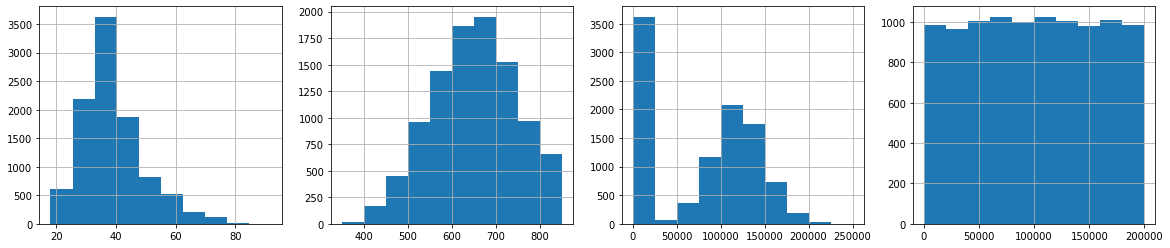

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4));
df['Age'].hist(ax=axes[0])
df['CreditScore'].hist(ax=axes[1])
df['Balance'].hist(ax=axes[2])
df['EstimatedSalary'].hist(ax=axes[3])

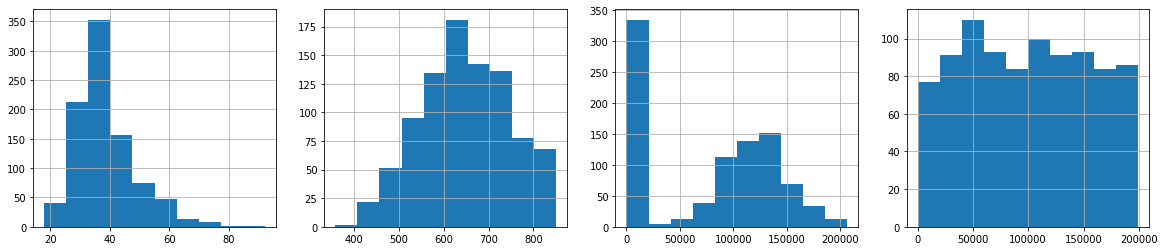

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4));
tenure['Age'].hist(ax=axes[0])
tenure['CreditScore'].hist(ax=axes[1])
tenure['Balance'].hist(ax=axes[2])
tenure['EstimatedSalary'].hist(ax=axes[3])

Гистограммы схожи. Скорее всего пропуск имеет случайный характер. 
Заменим пропуски случайным значением из доступного набора

In [12]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [13]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [14]:
#функция принимает значение 'Tenure', если оно равно -1 , возвращает случаное значение из списка 
#уникальных значений 'Tenure'
df['Tenure'].fillna(-1, inplace = True) 
def fuller (row):

    tenure = row['Tenure']

    if tenure == -1:
        return random.randint(0,10)
    else: 
        return tenure
df['Tenure'] = df.apply(fuller, axis = 1)


In [15]:
df['Tenure'].value_counts()

1.0     1038
2.0     1030
5.0     1010
7.0     1008
8.0     1007
3.0      994
4.0      976
6.0      972
9.0      961
10.0     533
0.0      471
Name: Tenure, dtype: int64

### 1.5 Кодирование 

Датасет содержит численные и категориальные признаки. Для логистической регресии проведем кодирование категориальных признаков. 

1. Пол

In [16]:
df.Gender.value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

В данном признаке только два значения. Для данного признака лучше подходит  порядковое кодирование. 

In [17]:
df.loc[:,'Gender'] = (df.Gender == 'Male').astype(int)
df.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2.0,125510.82,1,1,1,79084.10,0


2. География 

In [18]:
df.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

В данном признаке уже три значения. Попробуем два вида кодировки - порядковое и прямое. Результатом будет датасет, содержащий 
данный признак в двух видах кодировки. Каждый из которых будем удалять при необходимости. 

Прямое кодирование  

In [19]:
ohencoder = OneHotEncoder()
geo_ohe = ohencoder.fit_transform(df[['Geography']]).toarray()
geo_ohe = pd.DataFrame(geo_ohe, columns = ohencoder.categories_[0])


Удалим столбец 'France', информация об этом признаке содержиться в 'Germany', 'Spain'

In [20]:
geo_ohe.drop(['France'], axis = 1 , inplace = True)

In [21]:
geo_ohe.columns

Index(['Germany', 'Spain'], dtype='object')

In [22]:
geo_ohe.head(5)

,Germany,Spain
0,0.0,0.0
1,0.0,1.0
2,0.0,0.0
3,0.0,0.0
4,0.0,1.0


Порядковое кодирование 

In [23]:
ordinalenc = OrdinalEncoder()
geo_ord = ordinalenc.fit_transform(df[['Geography']])
geo_ord = pd.DataFrame(geo_ord, columns =['Geography'])

In [24]:
geo_ord.head(5)

,Geography
0,0.0
1,2.0
2,0.0
3,0.0
4,2.0


Соберем датасет 

In [25]:
df.loc[:,'Geography'] = geo_ord.loc[:,'Geography']
df = df.join(geo_ohe)

In [26]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Germany,Spain
0,619,0.0,0,42,2.0,0.00,1,1,1,101348.88,1,0.0,0.0
1,608,2.0,0,41,1.0,83807.86,1,0,1,112542.58,0,0.0,1.0
2,502,0.0,0,42,8.0,159660.80,3,1,0,113931.57,1,0.0,0.0
3,699,0.0,0,39,1.0,0.00,2,0,0,93826.63,0,0.0,0.0
4,850,2.0,0,43,2.0,125510.82,1,1,1,79084.10,0,0.0,1.0


### 1.6 Масштабирование численных признаков 

In [27]:
scaler = StandardScaler()
numeric = ['Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler.fit(df[numeric])
df[numeric] = scaler.transform(df[numeric])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Germany,Spain
0,619,0.0,0,0.293517,-1.025271,-1.225848,1,1,1,0.021886,1,0.0,0.0
1,608,2.0,0,0.198164,-1.367518,0.117350,1,0,1,0.216534,0,0.0,1.0
2,502,0.0,0,0.293517,1.028214,1.333053,3,1,0,0.240687,1,0.0,0.0
3,699,0.0,0,0.007457,-1.367518,-1.225848,2,0,0,-0.108918,0,0.0,0.0
4,850,2.0,0,0.388871,-1.025271,0.785728,1,1,1,-0.365276,0,0.0,1.0


# 2. Исследование задачи

Подготовим выборки 

In [28]:
X = df.drop(["Exited"], axis=1)
Y = df["Exited"]
X_train, X_valid,Y_train, Y_valid  = train_test_split(X,Y,  test_size=0.20, random_state=12345)
X_valid, X_test,Y_valid, Y_test  = train_test_split(X_valid,Y_valid,  test_size=0.50, random_state=12345)

Логистическая регрессия при пряммом кодировании (удаляем признак 'Geography')

In [29]:
logres = LogisticRegression(solver='liblinear',class_weight='balanced')
logres.fit(X_train.drop(['Geography'], axis = 1),Y_train)
predicted_valid = logres.predict(X_valid.drop(['Geography'], axis = 1))
print("Accuracy (обучающая выборка):{:.2f}".format(logres.score(X_train.drop(['Geography'], axis = 1),Y_train)))
print("Accuracy (валидационная выборка):{:.2f}".format(logres.score(X_valid.drop(['Geography'], axis = 1),Y_valid)))
print("Точность:{:.2f}".format(precision_score(Y_valid, predicted_valid)))
print("Полнота:{:.2f}".format(recall_score(Y_valid, predicted_valid)))
print("F1:{:.2f}".format(f1_score(Y_valid, predicted_valid)))

Accuracy (обучающая выборка):0.71
Accuracy (валидационная выборка):0.69
Точность:0.39
Полнота:0.70
F1:0.50


Логистическая регрессия при порядковом  кодировании (удаляем признаки  'Germany', 'Spain')

In [30]:
logres = LogisticRegression(solver='liblinear',class_weight='balanced')
logres.fit(X_train.drop(['Germany', 'Spain'], axis = 1),Y_train)
predicted_valid = logres.predict(X_valid.drop(['Germany', 'Spain'], axis = 1))
print("Accuracy (обучающая выборка):{:.2f}".format(logres.score(X_train.drop(['Germany', 'Spain'],
                                                                             axis = 1),Y_train)))
print("Accuracy (валидационная выборка):{:.2f}".format(logres.score(X_valid.drop(['Germany', 'Spain'],
                                                                                 axis = 1),Y_valid)))
print("Точность:{:.2f}".format(precision_score(Y_valid, predicted_valid)))
print("Полнота:{:.2f}".format(recall_score(Y_valid, predicted_valid)))
print("F1:{:.2f}".format(f1_score(Y_valid, predicted_valid)))


Accuracy (обучающая выборка):0.70
Accuracy (валидационная выборка):0.67
Точность:0.37
Полнота:0.68
F1:0.48


Логистическая регрессия не дала планового показателя F1 да же с учетом дисбаланса классов (class_weight='balanced')

 
Случайный лес при прямом кодировании (удаляем признак 'Geography')

In [31]:
RF= RandomForestClassifier(random_state=12345, max_depth = 10)
RF.fit(X_train.drop(['Geography'], axis = 1),Y_train)
predicted_valid = RF.predict(X_valid.drop(['Geography'], axis = 1))
print("Accuracy (обучающая выборка):{:.2f}".format(RF.score(X_train.drop(['Geography'], axis = 1),Y_train)))
print("Accuracy (валидационная выборка):{:.2f}".format(RF.score(X_valid.drop(['Geography'], axis = 1),Y_valid)))
print("Точность:{:.2f}".format(precision_score(Y_valid, predicted_valid)))
print("Полнота:{:.2f}".format(recall_score(Y_valid, predicted_valid)))
print("F1:{:.2f}".format(f1_score(Y_valid, predicted_valid)))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy (обучающая выборка):0.90
Accuracy (валидационная выборка):0.85
Точность:0.79
Полнота:0.44
F1:0.56


Случайный лес при порядковом кодировании (удаляем признаки 'France', 'Germany', 'Spain')

In [32]:
RF= RandomForestClassifier(random_state=12345, max_depth = 10)
RF.fit(X_train.drop(['Germany', 'Spain'], axis = 1),Y_train)
predicted_valid = RF.predict(X_valid.drop(['Germany', 'Spain'], axis = 1))
print("Accuracy (обучающая выборка):{:.2f}".format(RF.score(X_train.drop(['Germany', 'Spain'],
                                                                             axis = 1),Y_train)))
print("Accuracy (валидационная выборка):{:.2f}".format(RF.score(X_valid.drop(['Germany', 'Spain'],
                                                                                 axis = 1),Y_valid)))
print("Точность:{:.2f}".format(precision_score(Y_valid, predicted_valid)))
print("Полнота:{:.2f}".format(recall_score(Y_valid, predicted_valid)))
print("F1:{:.2f}".format(f1_score(Y_valid, predicted_valid)))

Accuracy (обучающая выборка):0.90
Accuracy (валидационная выборка):0.85
Точность:0.81
Полнота:0.42
F1:0.55


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Случайный лес так же не дал планового показателя F1. Дисбаланс классов все еще не дает алгоритмам сделать точную модель. 
Попробуем исправить ситуацию с помощью искуственного изменения баланса классов. 


# 3. Борьба с дисбалансом

Посмотрим на сколько отличаются классы 

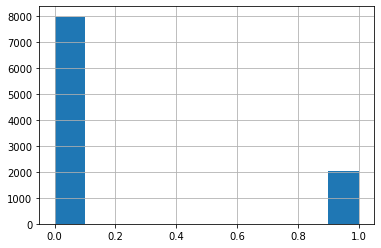

In [33]:
df.Exited.hist()

### 3.1 Увеличение выборки

По графику видно что положительных резульатов меньше в 4 раза. При таком дисбалансе алогоритмы не дают необходимой точности. 

Разделим тренировочную выборку на отрицательные и положительные части. 

In [34]:
ex_0_index = Y_train[Y_train == 0].index
ex_1_index = Y_train[Y_train != 0].index
ex_0 = df.loc[ex_0_index]
ex_1 = df.loc[ex_1_index]

Найдем разницу в тренировочной выборке между классами

In [35]:
difference = int((ex_0.shape[0] - ex_1.shape[0])*0.6)
difference

2868

Синтизируем новую выборку   из слуслучайных элементов в положительном классе.

In [36]:
up_df = ex_1.sample(difference, replace = True).drop(['Exited'], axis=1)
up_y_df = Y_train.loc[up_df.index]
up_y_df.shape, up_df.shape

((2868,), (2868, 12))

Добавим новую выборку с положительным классом в тренировочный датасет

In [37]:
X_upsampling_train = pd.concat([X_train, up_df])
Y_upsampling_train = np.hstack((Y_train.values,up_y_df.values))
X_upsampling_train.shape, Y_upsampling_train.shape

((10868, 12), (10868,))

И так мы получили новую тренировочную выборку с балансом классов 50/50

### 3.2 Уменьшение выборки

Выделим из тренировочной выборки новый датасет с отрицательным классом, так что бы его размер соответсвовал размеру
положительного класса в той же тренировочной выборке

In [38]:
down_df = ex_0.sample(ex_1.shape[0]).drop(['Exited'], axis=1)
down_y_df = Y_train.loc[down_df.index]
down_y_df.shape, down_df.shape

((1610,), (1610, 12))

Объединим два датасета в один

In [39]:
X_downsampling_train = pd.concat([down_df, ex_1])
Y_downsampling_train = np.hstack((down_y_df.values,Y_train[Y_train != 0].values))
X_downsampling_train.shape,Y_downsampling_train.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


((3220, 13), (3220,))

Проверим что у нас получилось.

In [40]:
np.unique(Y_downsampling_train, return_counts = True)

(array([0, 1]), array([1610, 1610]))

In [41]:
np.unique(Y_upsampling_train, return_counts = True)

(array([0, 1]), array([6390, 4478]))

И так у нас есть две тренировочные выборки с балансом классов 50/50 

### 3.3 Обучение моделей на выборках с балансированными классами

Увеличенная выборка. Случайный лес при порядковом кодировании.

In [42]:
RF_up1 = RandomForestClassifier(random_state=12345, max_depth = 10)
RF_up1.fit(X_upsampling_train.drop(['Germany', 'Spain'], axis = 1),Y_upsampling_train)
predicted_valid = RF_up1.predict(X_valid.drop(['Germany', 'Spain'], axis = 1))
print("Accuracy (обучающая выборка):{:.2f}".format(RF_up1.score(X_upsampling_train.drop(['Germany', 'Spain'],
                                                                                       axis = 1),Y_upsampling_train)))
print("Accuracy (валидационная выборка):{:.2f}".format(RF_up1.score(X_valid.drop(['Germany', 'Spain'], 
                                                                                axis = 1),Y_valid)))
print("Точность:{:.2f}".format(precision_score(Y_valid, predicted_valid)))
print("Полнота:{:.2f}".format(recall_score(Y_valid, predicted_valid)))
print("F1:{:.2f}".format(f1_score(Y_valid, predicted_valid)))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy (обучающая выборка):0.89
Accuracy (валидационная выборка):0.83
Точность:0.64
Полнота:0.61
F1:0.62


Увеличенная выборка. Случайный лес при прямом кодировании 

In [43]:
RF_up2 = RandomForestClassifier(random_state=12345, max_depth = 10)
RF_up2.fit(X_upsampling_train.drop(['Geography'], axis = 1),Y_upsampling_train)
predicted_valid = RF_up2.predict(X_valid.drop(['Geography'], axis = 1))
print("Accuracy (обучающая выборка):{:.2f}".format(RF_up2.score(X_upsampling_train.drop(['Geography'], axis = 1),Y_upsampling_train)))
print("Accuracy (валидационная выборка):{:.2f}".format(RF_up2.score(X_valid.drop(['Geography'], axis = 1),Y_valid)))
print("Точность:{:.2f}".format(precision_score(Y_valid, predicted_valid)))
print("Полнота:{:.2f}".format(recall_score(Y_valid, predicted_valid)))
print("F1:{:.2f}".format(f1_score(Y_valid, predicted_valid)))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy (обучающая выборка):0.89
Accuracy (валидационная выборка):0.85
Точность:0.69
Полнота:0.61
F1:0.65


Уменьшенная выборка. Случайный лес при порядковом кодировании.

In [44]:
RF_down = RandomForestClassifier(random_state=12345, max_depth = 10)
RF_down.fit(X_downsampling_train.drop(['Germany', 'Spain','Exited'], axis = 1),Y_downsampling_train)
predicted_valid = RF_down.predict(X_valid.drop(['Germany', 'Spain'], axis = 1))
print("Accuracy (обучающая выборка):{:.2f}".format(RF_down.score(X_downsampling_train.drop(['Germany', 'Spain','Exited'], axis = 1),Y_downsampling_train)))
print("Accuracy (валидационная выборка):{:.2f}".format(RF_down.score(X_valid.drop(['Germany', 'Spain'], axis = 1),Y_valid)))
print("Точность:{:.2f}".format(precision_score(Y_valid, predicted_valid)))
print("Полнота:{:.2f}".format(recall_score(Y_valid, predicted_valid)))
print("F1:{:.2f}".format(f1_score(Y_valid, predicted_valid)))

Accuracy (обучающая выборка):0.90
Accuracy (валидационная выборка):0.48
Точность:0.24
Полнота:0.59
F1:0.34


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Уменьшенная  выборка. Случайный лес при прямом кодировании

In [45]:
RF_down = RandomForestClassifier(random_state=12345, max_depth = 10)
RF_down.fit(X_downsampling_train.drop(['Geography','Exited'], axis = 1),Y_downsampling_train)
predicted_valid = RF_down.predict(X_valid.drop(['Geography'], axis = 1))
print("Accuracy (обучающая выборка):{:.2f}".format(RF_down.score(X_downsampling_train.drop(['Geography','Exited'], axis = 1),Y_downsampling_train)))
print("Accuracy (валидационная выборка):{:.2f}".format(RF_down.score(X_valid.drop(['Geography'], axis = 1),Y_valid)))
print("Точность:{:.2f}".format(precision_score(Y_valid, predicted_valid)))
print("Полнота:{:.2f}".format(recall_score(Y_valid, predicted_valid)))
print("F1:{:.2f}".format(f1_score(Y_valid, predicted_valid)))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy (обучающая выборка):0.89
Accuracy (валидационная выборка):0.40
Точность:0.24
Полнота:0.80
F1:0.37


Лучший результат получился при прямом кодировании и при увеличении выборки

# 4. Тестирование модели

Лучший показатель показала модель RF_up2(Увеличенная выборка. Случайный лес при прямом кодировании)

Протестируем модель на тестовой выборке 

In [46]:
RF_up2 = RandomForestClassifier(random_state=12345, max_depth = 10)
RF_up2.fit(X_upsampling_train.drop(['Geography'], axis = 1),Y_upsampling_train)
predicted_test = RF_up2.predict(X_test.drop(['Geography'], axis = 1))
print("Точность:{:.2f}".format(precision_score(Y_test, predicted_test)))
print("Полнота:{:.2f}".format(recall_score(Y_test, predicted_test)))
print("F1:{:.2f}".format(f1_score(Y_test, predicted_test)))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Точность:0.60
Полнота:0.58
F1:0.59


Данная модель показывает F1 не менее 0.59. Плановый показатель достигнут. 

Посмотрим на сколько наша модель адекватна. 
Посчитаем показатель аuc_roc

In [47]:
probabilities_test = RF_up2.predict_proba(X_test.drop(['Geography'], axis = 1))
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(Y_test, probabilities_one_test)
print(auc_roc)


0.8573692895605349


Показатель аuc_roc = 0.867  или почти 9 из 10 ответов модель предсказывает верно.

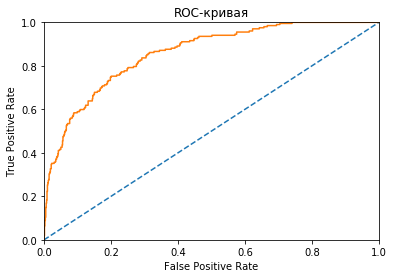

In [48]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_one_test)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot (fpr,tpr)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


Посмотрим какие признаки влияют больше , а какие меньше на уход клиента. 

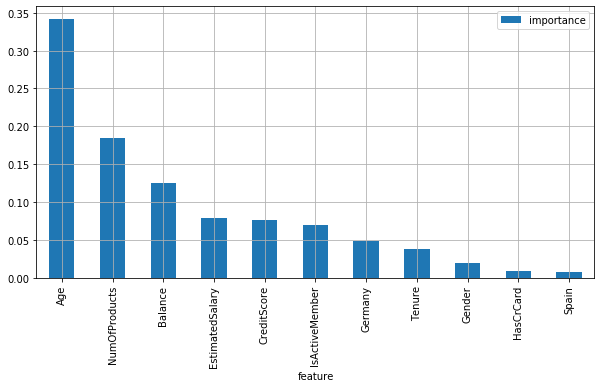

In [49]:
fi = pd.DataFrame({'feature': list(X_upsampling_train.drop(['Geography'], axis = 1).columns),
                   'importance': RF_up2.feature_importances_}).sort_values('importance', ascending = False)

fi.plot(kind='bar', y='importance',grid=True, figsize=(10,5), x= 'feature' )

In [50]:
fi

,feature,importance
2,Age,0.341367
5,NumOfProducts,0.184305
4,Balance,0.124732
8,EstimatedSalary,0.078994
0,CreditScore,0.077001
7,IsActiveMember,0.069877
9,Germany,0.048906
3,Tenure,0.037890
1,Gender,0.019566
6,HasCrCard,0.009561


Более всего уход клиента связан с возрастом. Такие признаки как пол, география, наличие недвижимости влияют менее всего. 

Наилучшим алгоритмом стал случайный лес. Дисбаланс классов лучше исправить методом увеличения выборки искуственными данными. 
Категориальные признаки лучше кодировать прямым методом. 